# EDA (Exploratory Data Analysis) - Medication Object Detection Dataset

이 노트북은 경구약제 이미지 객체 검출 데이터셋에 대한 탐색적 데이터 분석(EDA)을 수행합니다. 데이터셋의 구조, 약품 정보, 바운딩 박스 특성 등을 파악하여 향후 데이터 전처리 및 모델링 전략 수립에 활용합니다.

In [1]:
import os
import json
import random

from pathlib import Path
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
import seaborn as sns # Added for visualization

from PIL import Image, ImageDraw, ImageFont


import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt # Added for visualization
import matplotlib.patches as patches
from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 
pd.set_option('future.no_silent_downcasting', True)


import Project.src.config as config

def collect_annotation_data(annotation_dir):
    data = defaultdict(list)
    for root, _, files in os.walk(annotation_dir):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    annotation = json.load(f)
                
                # Extract image metadata
                if 'images' in annotation and len(annotation['images']) > 0:
                    image_info = annotation['images'][0]
                    data['file_name'].append(image_info.get('file_name'))
                    data['width'].append(image_info.get('width'))
                    data['height'].append(image_info.get('height'))
                    data['dl_name'].append(image_info.get('dl_name'))
                    data['drug_shape'].append(image_info.get('drug_shape'))
                    data['color_class1'].append(image_info.get('color_class1'))
                    data['print_front'].append(image_info.get('print_front'))
                    data['print_back'].append(image_info.get('print_back'))
                else:
                    # Handle cases where 'images' key might be missing or empty
                    data['file_name'].append(None)
                    data['width'].append(None)
                    data['height'].append(None)
                    data['dl_name'].append(None)
                    data['drug_shape'].append(None)
                    data['color_class1'].append(None)
                    data['print_front'].append(None)
                    data['print_back'].append(None)

                # Extract bounding box data
                if 'annotations' in annotation:
                    for ann in annotation['annotations']:
                        bbox = ann.get('bbox')
                        if bbox:
                            data['bbox_x'].append(bbox[0])
                            data['bbox_y'].append(bbox[1])
                            data['bbox_width'].append(bbox[2])
                            data['bbox_height'].append(bbox[3])
                        else:
                            data['bbox_x'].append(None)
                            data['bbox_y'].append(None)
                            data['bbox_width'].append(None)
                            data['bbox_height'].append(None)
                        
                        # Ensure all lists have the same length for DataFrame creation
                        # This is a simplified approach; a more robust solution might involve
                        # creating a separate DataFrame for annotations and merging later.
                        # For EDA, we'll just append None for image-level data if no bbox
                        if not bbox:
                            data['file_name'].append(None)
                            data['width'].append(None)
                            data['height'].append(None)
                            data['dl_name'].append(None)
                            data['drug_shape'].append(None)
                            data['color_class1'].append(None)
                            data['print_front'].append(None)
                            data['print_back'].append(None)

    return pd.DataFrame(data)

annotation_base_dir = './data/ai03-level1-project/train_annotations'
print(f'Collecting annotation data from: {annotation_base_dir}')
df = collect_annotation_data(annotation_base_dir)

In [2]:
df

,file_name,width,height,dl_name,drug_shape,color_class1,print_front,print_back,bbox_x,bbox_y,bbox_width,bbox_height
0,K-003483-025367-027777-035206_0_2_0_2_75_000_2...,976,1280,카나브정 60mg,육각형,노랑,B분할선R,FMS6,145,775,180,206
1,K-003483-025367-027777-035206_0_2_0_2_70_000_2...,976,1280,카나브정 60mg,육각형,노랑,B분할선R,FMS6,638,293,177,196
2,K-003483-025367-027777-035206_0_2_0_2_90_000_2...,976,1280,카나브정 60mg,육각형,노랑,B분할선R,FMS6,176,812,177,199
3,K-003483-025367-027777-035206_0_2_0_2_75_000_2...,976,1280,자누메트정 50/850mg,타원형,분홍,515,,566,726,409,481
4,K-003483-025367-027777-035206_0_2_0_2_70_000_2...,976,1280,자누메트정 50/850mg,타원형,분홍,515,,566,726,409,481
...,...,...,...,...,...,...,...,...,...,...,...,...
5506,K-003351-020014-020238_0_2_0_2_75_000_200.png,976,1280,일양하이트린정 2mg,원형,주황,I분할선Y,HT,345,186,185,191
5507,K-003351-020014-020238_0_2_0_2_90_000_200.png,976,1280,일양하이트린정 2mg,원형,주황,I분할선Y,HT,185,249,188,183
5508,K-003351-020014-020238_0_2_0_2_70_000_200.png,976,1280,일양하이트린정 2mg,원형,주황,I분할선Y,HT,401,846,191,196
5509,K-003351-020014-020238_0_2_0_2_75_000_200.png,976,1280,플라빅스정 75mg,원형,분홍,75,1171,529,731,231,229


## 데이터 개요

In [3]:
print('--- Data Overview ---')
print(df.head())
print(f'Total annotations collected: {len(df)}')

--- Data Overview ---
                                           file_name  width  height  \
0  K-003483-025367-027777-035206_0_2_0_2_75_000_2...    976    1280   
1  K-003483-025367-027777-035206_0_2_0_2_70_000_2...    976    1280   
2  K-003483-025367-027777-035206_0_2_0_2_90_000_2...    976    1280   
3  K-003483-025367-027777-035206_0_2_0_2_75_000_2...    976    1280   
4  K-003483-025367-027777-035206_0_2_0_2_70_000_2...    976    1280   

          dl_name drug_shape color_class1 print_front print_back  bbox_x  \
0       카나브정 60mg        육각형           노랑       B분할선R       FMS6     145   
1       카나브정 60mg        육각형           노랑       B분할선R       FMS6     638   
2       카나브정 60mg        육각형           노랑       B분할선R       FMS6     176   
3  자누메트정 50/850mg        타원형           분홍         515                566   
4  자누메트정 50/850mg        타원형           분홍         515                566   

   bbox_y  bbox_width  bbox_height  
0     775         180          206  
1     293         17

## 결측치 확인

In [4]:
print('--- Missing Values ---')
print(df.isnull().sum())

--- Missing Values ---
file_name         0
width             0
height            0
dl_name           0
drug_shape      171
color_class1    171
print_front     171
print_back      171
bbox_x            0
bbox_y            0
bbox_width        0
bbox_height       0
dtype: int64


## 약품 이름 분포 (상위 10개)

In [5]:
print('--- Unique Drug Names (Top 10) ---')
print(df['dl_name'].value_counts().head(10))

--- Unique Drug Names (Top 10) ---
dl_name
기넥신에프정(은행엽엑스)(수출용)    609
일양하이트린정 2mg           283
보령부스파정 5mg            222
뮤테란캡슐 100mg           217
동아가바펜틴정 800mg         173
가바토파정 100mg           171
아토젯정 10/40mg          135
리피토정 20mg             135
리바로정 4mg              135
크레스토정 20mg            134
Name: count, dtype: int64


## 약품 형태 분포

In [6]:
print('--- Drug Shape Distribution ---')
print(df['drug_shape'].value_counts())

--- Drug Shape Distribution ---
drug_shape
원형     1823
타원형    1760
장방형    1549
육각형     101
팔각형      95
기타       12
Name: count, dtype: int64


## 바운딩 박스 크기 및 종횡비 분석

In [7]:
print('--- Bounding Box Dimensions (Mean, Std, Min, Max) ---')
print(df[['bbox_width', 'bbox_height']].describe())

# Calculate aspect ratio
df['bbox_aspect_ratio'] = df['bbox_width'] / df['bbox_height']
print('--- Bounding Box Aspect Ratio Distribution ---')
print(df['bbox_aspect_ratio'].describe())

--- Bounding Box Dimensions (Mean, Std, Min, Max) ---
        bbox_width  bbox_height
count  5511.000000  5511.000000
mean    259.568499   289.215932
std      70.152212   116.871986
min     125.000000   123.000000
25%     209.000000   200.000000
50%     242.000000   231.000000
75%     295.000000   402.000000
max     529.000000   669.000000
--- Bounding Box Aspect Ratio Distribution ---
count    5511.000000
mean        0.985784
std         0.310998
min         0.396084
25%         0.758763
50%         1.011050
75%         1.100784
max         2.108374
Name: bbox_aspect_ratio, dtype: float64


## 이미지 해상도 분포

In [8]:
print('--- Image Resolution Distribution ---')
print(df[['width', 'height']].describe())

--- Image Resolution Distribution ---
        width  height
count  5511.0  5511.0
mean    976.0  1280.0
std       0.0     0.0
min     976.0  1280.0
25%     976.0  1280.0
50%     976.0  1280.0
75%     976.0  1280.0
max     976.0  1280.0


## 약품 색상 분포 (상위 10개)

In [9]:
print('--- Color Class Distribution (Top 10) ---')
print(df['color_class1'].value_counts().head(10))

--- Color Class Distribution (Top 10) ---
color_class1
하양        1604
노랑         853
분홍         853
초록         826
주황         539
갈색         368
파랑         102
빨강          99
연두          72
노랑, 투명      24
Name: count, dtype: int64


## 각인 정보 분포 (상위 10개)

In [10]:
print('--- Print Front Distribution (Top 10) ---')
print(df['print_front'].value_counts().head(10))

print('--- Print Back Distribution (Top 10) ---')
print(df['print_back'].value_counts().head(10))

--- Print Front Distribution (Top 10) ---
print_front
SK               649
마크               605
I분할선Y            283
BSP              228
Hanwha MUC100    217
YH               203
DGTH             173
337              135
마크203            135
ATV              135
Name: count, dtype: int64
--- Print Back Distribution (Top 10) ---
print_back
          2044
G40        609
분할선        368
HT         283
5          228
20         176
800        173
1171       116
D5         105
D2/850     102
Name: count, dtype: int64


## 추가 시각화

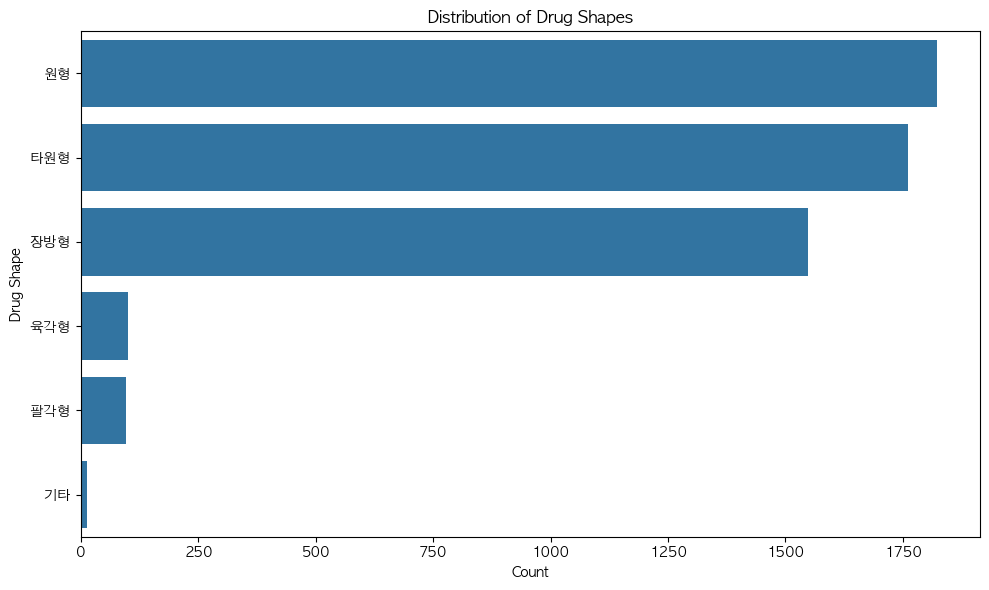

In [11]:
# 1. Drug Shape Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='drug_shape', order=df['drug_shape'].value_counts().index)
plt.title('Distribution of Drug Shapes')
plt.xlabel('Count')
plt.ylabel('Drug Shape')
plt.tight_layout()
plt.show()


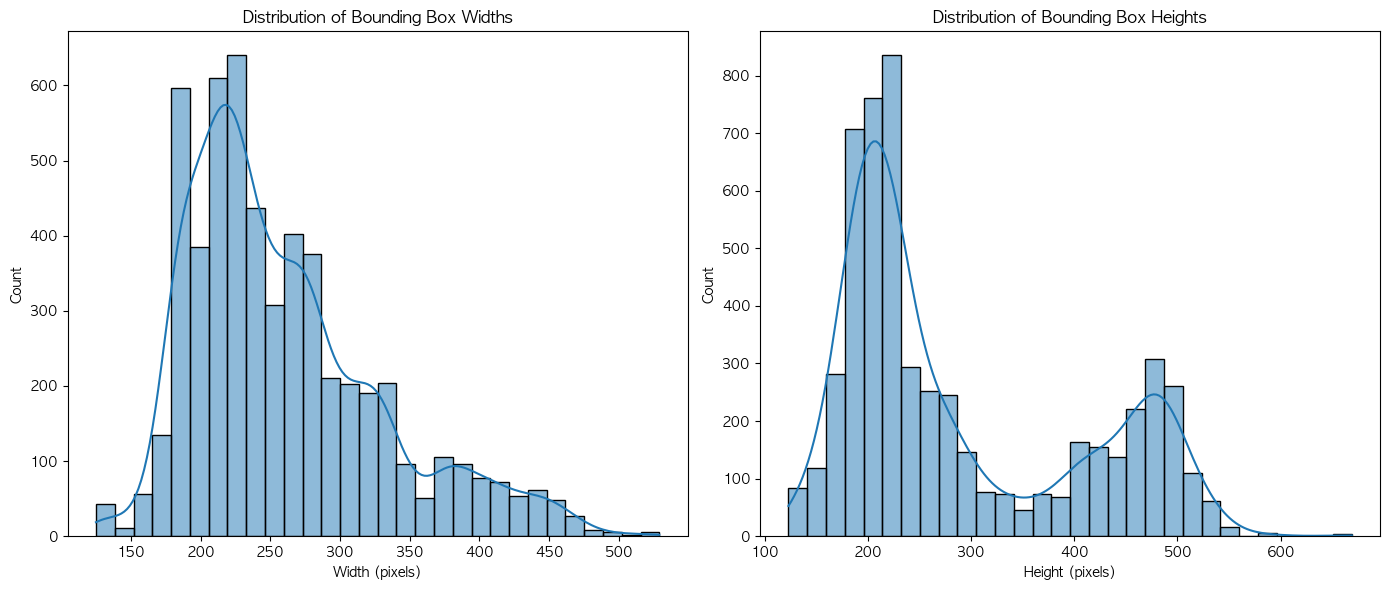

In [12]:
# 2. Bounding Box Width and Height Distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['bbox_width'], bins=30, kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(df['bbox_height'], bins=30, kde=True)
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


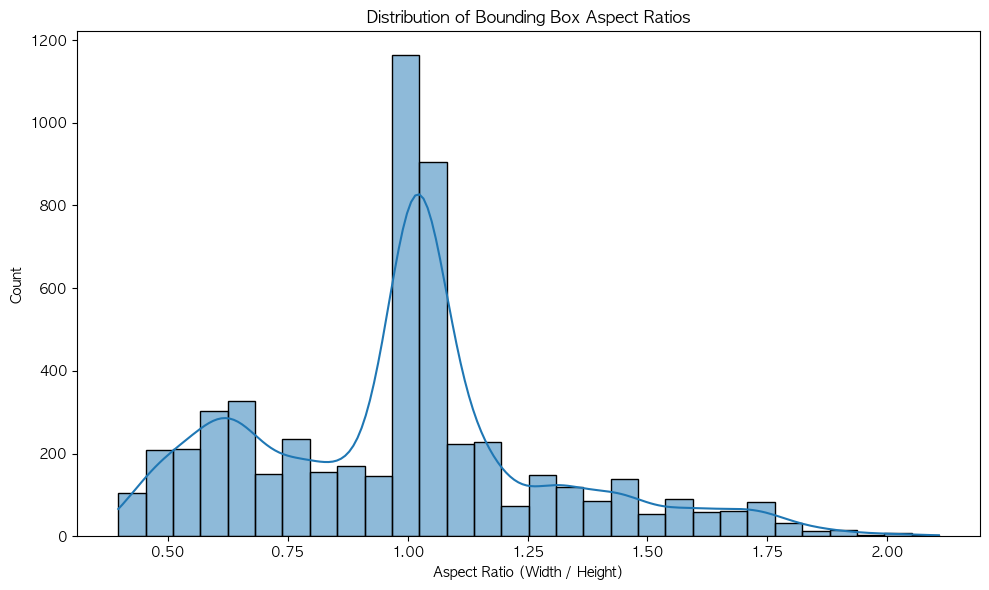

In [13]:
# 3. Bounding Box Aspect Ratio Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['bbox_aspect_ratio'], bins=30, kde=True)
plt.title('Distribution of Bounding Box Aspect Ratios')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


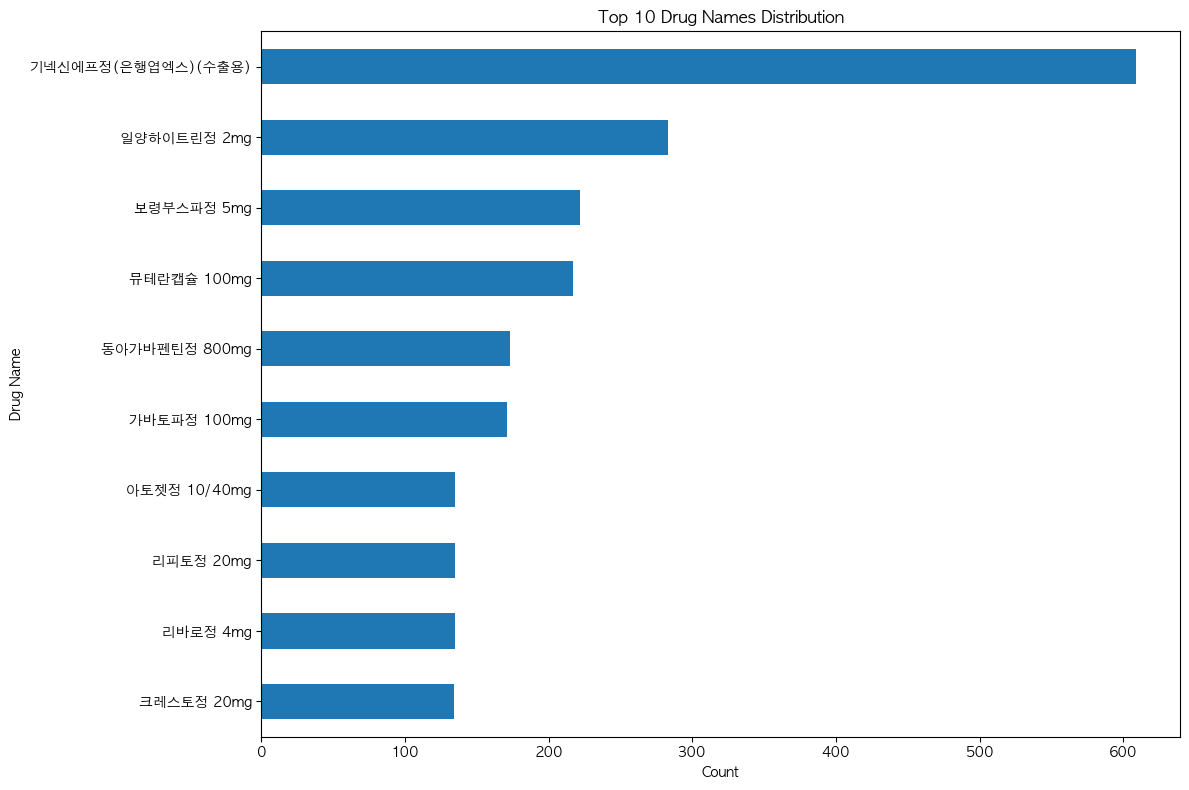

In [14]:
# 4. Top 10 Drug Names Distribution
plt.figure(figsize=(12, 8))
df['dl_name'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Drug Names Distribution')
plt.xlabel('Count')
plt.ylabel('Drug Name')
plt.gca().invert_yaxis() # To show the highest count at the top
plt.tight_layout()
plt.show()


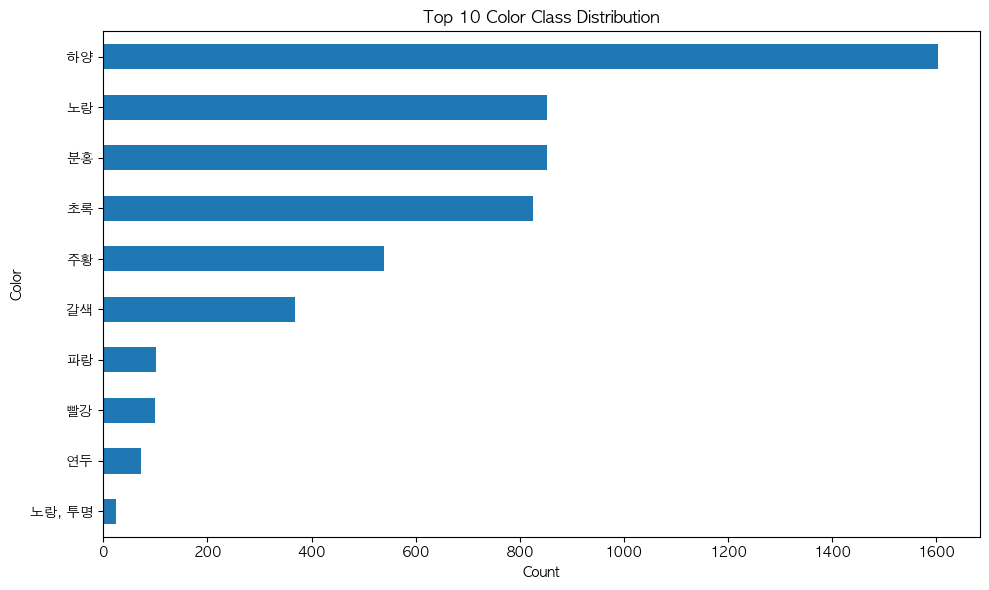

In [15]:
# 5. Top 10 Color Class Distribution
plt.figure(figsize=(10, 6))
df['color_class1'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Color Class Distribution')
plt.xlabel('Count')
plt.ylabel('Color')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [16]:
# 이미지와 어노테이션을 로드하는 헬퍼 함수
def load_image_and_annotations(image_filename, img_base_dir, annotation_base_dir):
    img_path = os.path.join(img_base_dir, image_filename)
    image = Image.open(img_path).convert("RGB")
    
	# 어노테이션 파일 경로 구성 로직 수정
    # 예: K-001900-010224-016551-031705_0_2_0_2_70_000_200.png
    # -> K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_70_000_200.json
    # 첫 번째 디렉토리 이름 (예: K-001900-010224-016551-031705_json)
    # 이미지 파일명에서 첫 번째 '_' 앞부분을 추출하고 '_json'을 붙임
    base_id_part = image_filename.split('_')[0]
    annotation_dir_name = base_id_part + '_json'
    
	# 두 번째 디렉토리 이름 (예: K-001900)
    # base_id_part에서 첫 번째 '-'와 두 번째 '-' 사이의 부분을 추출
    # K-001900-010224-016551-031705 -> ['K', '001900', '010224', '016551', '031705'] -> 'K-001900'
    annotation_file_name = image_filename.replace('.png', '.json')
    
    bboxes = []
    labels = []
    for key in base_id_part.split('-'):
        if 'K' == key.upper():
            continue

        annotation_sub_dir_name = f"K-{key}"
        
		# 최종 JSON 파일명은 이미지 파일명과 동일 (확장자만 .json)
        json_path = os.path.join(annotation_base_dir, annotation_dir_name, annotation_sub_dir_name, annotation_file_name)
        if os.path.exists(json_path):
            with open(json_path, 'r', encoding='utf-8') as f:
                annotation_data = json.load(f)
            if 'annotations' in annotation_data:
                for ann in annotation_data['annotations']:
                    bbox = ann.get('bbox') # [x, y, width, height]
                    category_id = ann.get('category_id')
                    if bbox and category_id is not None:
                        # Find the corresponding category name
                        category_name = next((cat['name'] for cat in annotation_data.get('categories', []) if cat['id'] == category_id), str(category_id))
                        bboxes.append(bbox)
                        labels.append(category_name)
        else:
            print(f"Warning: Annotation file not found for {image_filename} at {json_path}")
    return image, bboxes, labels

# 바운딩 박스와 라벨을 이미지에 그리는 헬퍼 함수
def draw_boxes_on_image(ax, image, bboxes, labels):
    ax.imshow(image)
    ax.set_axis_off()

    for bbox, label in zip(bboxes, labels):
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x, y - 10, label, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0))

## 무작위 트레인 이미지 및 어노테이션 시각화

In [ ]:
# 이미지 및 어노테이션 기본 경로
IMG_BASE_DIR = './data/ai03-level1-project/train_images'
ANNOTATION_BASE_DIR = './data/ai03-level1-project/train_annotations'

# 모든 이미지 파일 이름 가져오기
all_image_files = []
for root, _, files in os.walk(IMG_BASE_DIR):
    for file in files:
        if file.endswith('.png'): # Assuming images are PNG
            all_image_files.append(file)
all_image_files = sorted(all_image_files)

# 시각화할 이미지 개수 설정
num_images_to_visualize = 3
split_cnt = 135


In [913]:
split_cnt += 1
print(split_cnt)

135


405 : 408


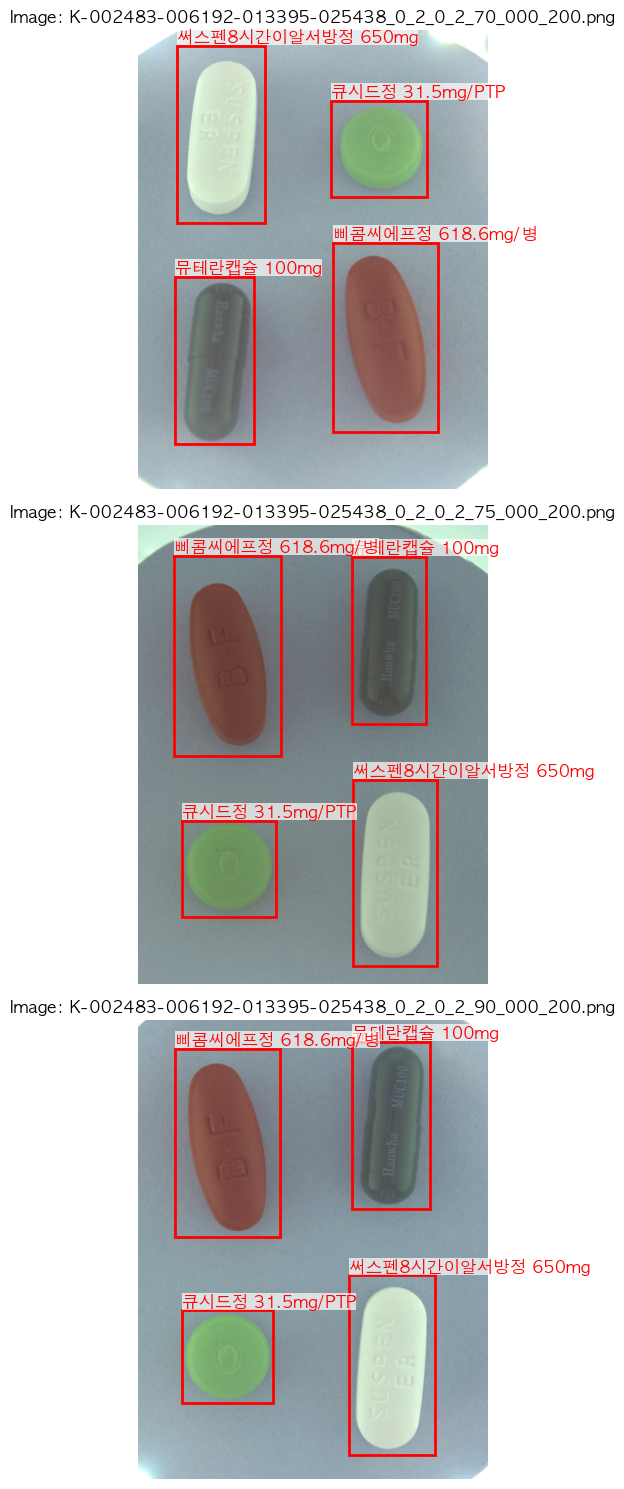

In [923]:
print(num_images_to_visualize*split_cnt, ':', num_images_to_visualize*split_cnt+num_images_to_visualize)

# selected_image_files = random.sample(all_image_files, num_images_to_visualize)
selected_image_files = all_image_files[num_images_to_visualize*split_cnt:num_images_to_visualize*split_cnt+num_images_to_visualize]
plt.figure(figsize=(20, 5 * num_images_to_visualize)) # Adjust figure size as needed
for i, image_filename in enumerate(selected_image_files):
    image, bboxes, labels = load_image_and_annotations(image_filename, IMG_BASE_DIR, ANNOTATION_BASE_DIR)
    ax = plt.subplot(num_images_to_visualize, 1, i + 1)
    draw_boxes_on_image(ax, image, bboxes, labels)
    ax.set_title(f"Image: {image_filename}") # Display first drug name if available
plt.tight_layout()
plt.show()

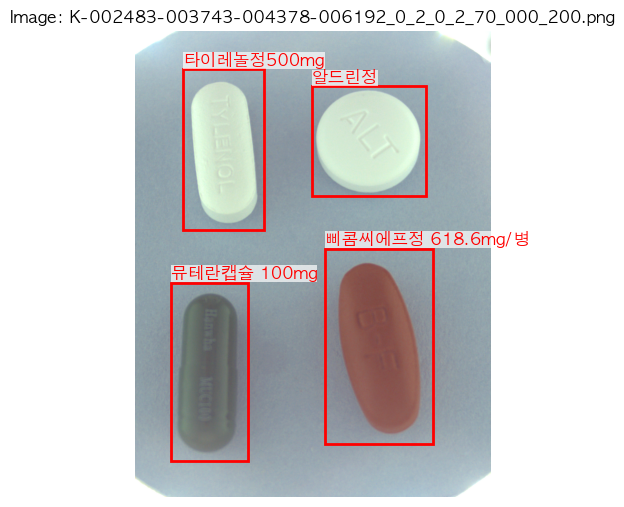

In [20]:
image_filename = 'K-002483-003743-004378-006192_0_2_0_2_70_000_200.png'

plt.figure(figsize=(20, 5 * num_images_to_visualize)) # Adjust figure size as needed
image, bboxes, labels = load_image_and_annotations(image_filename, IMG_BASE_DIR, ANNOTATION_BASE_DIR)
ax = plt.subplot(num_images_to_visualize, 1, i + 1)
draw_boxes_on_image(ax, image, bboxes, labels)
ax.set_title(f"Image: {image_filename}") # Display first drug name if available
plt.tight_layout()
plt.show()

In [21]:
class PillDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(self.image_dir, img_name)

        # OpenCV로 이미지 로딩
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        ann_dir = os.path.join(self.annotation_dir, f"{img_id.split('_')[0]}_json")
        bboxes = []
        labels = []

        for dirname in os.listdir(ann_dir):
            for file in os.listdir(os.path.join(ann_dir, dirname)):
                if file.endswith(".json") and img_id in file:
                    with open(os.path.join(ann_dir, dirname, file), "r") as f:
                        ann = json.load(f)
                        label = ann["categories"][0]["name"]
                        class_id = ann["annotations"][0]["category_id"]
                        if class_id == -1:
                            continue
                        x, y, bw, bh = ann["annotations"][0]["bbox"]
                        x_min, y_min = x, y
                        x_max, y_max = x + bw, y + bh
                        bboxes.append([x_min, y_min, x_max, y_max])
                        labels.append(class_id)

        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, labels=labels)
            image = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['labels']

        # 변환된 bbox (pascal_voc) → YOLO 포맷으로 변환
        targets = []
        for bbox, label in zip(bboxes, labels):
            x_min, y_min, x_max, y_max = bbox
            bw = x_max - x_min
            bh = y_max - y_min
            x_c = x_min + bw / 2
            y_c = y_min + bh / 2
            x_c /= image.shape[2]  # width
            y_c /= image.shape[1]  # height
            bw /= image.shape[2]
            bh /= image.shape[1]
            targets.append([label, x_c, y_c, bw, bh])

        return image, torch.tensor(targets, dtype=torch.float32)

# --- 데이터 증강 및 변환 정의 ---
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=15, p=0.3),
        ToTensorV2() # 이미지를 PyTorch 텐서로 변환
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_valid_transform():
    return A.Compose([
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


def collate_fn(batch):
    return tuple(zip(*batch))


def getPillDataloader(dataset):
    # 1. 데이터셋 및 데이터로더
    print("Loading data...")
    
    data_loader = DataLoader(
        dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        # num_workers=4 # CPU 코어 수에 맞게 조절
    )

    return data_loader

dataset = PillDataset(
	image_dir='./data/ai03-level1-project/train_images',
	annotation_dir='./data/ai03-level1-project/train_annotations',
	transform=get_train_transform()
)
    
dl = getPillDataloader(dataset)

Loading data...


In [22]:
def visualize_sample(image, targets):
    """
    image: torch.Tensor (3, H, W)
    targets: list of [class_id, x_center, y_center, width, height]
    class_names: list of class names corresponding to class_id
    """
    image_np = image.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)

    h, w, _ = image_np.shape
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image_np)

    for box in targets:
        class_id, x_c, y_c, bw, bh = box
        # YOLO → 좌상단 좌표로 변환
        x = (x_c - bw / 2) * w
        y = (y_c - bh / 2) * h
        box_w = bw * w
        box_h = bh * h

        rect = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, int(class_id), color='white', fontsize=12,
                    bbox=dict(facecolor='red', alpha=0.5, edgecolor='none'))

    plt.axis('off')
    plt.show()

In [23]:
idx = 0

0


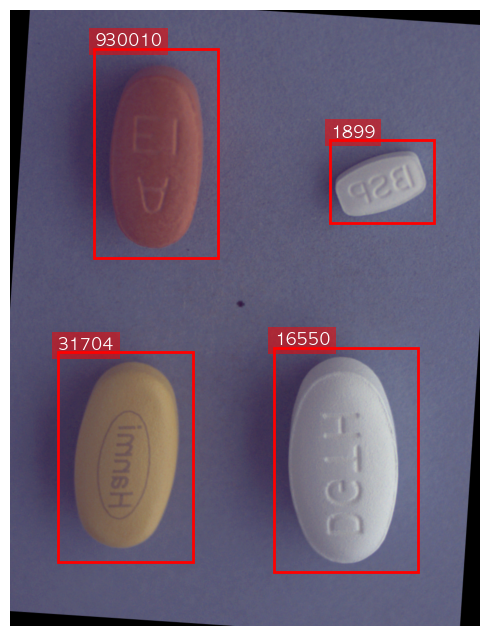

In [24]:
print(idx)
# 하나 꺼내서 시각화
image, targets = dataset[idx]  # image: tensor, targets: tensor

visualize_sample(image, targets)

idx += 1